<a href="https://colab.research.google.com/github/stanislavfort/adversaries_to_OOD_detection/blob/main/adversaries_to_strong_OOD_detectors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Replicating the key results from
# **Adversarial vulnerability of powerful near out-of-distribution detection** 
by Stanislav Fort

This is Colab performs a key experiments from **Adversarial vulnerability of powerful near out-of-distribution detection** by Stanisalv Fort. It uses a large, pretrained and finetuned [Vision Transformer](https://arxiv.org/abs/2010.11929), extracts its embeddings, and performs OOD detection on the hard near-OOD [CIFAR-100 vs CIFAR-10 task](https://paperswithcode.com/sota/out-of-distribution-detection-on-cifar-100-vs). It then calculates adversarial examples against the Mahalanobis distance and *Relative* Mahalanobis distance scores and shows how the AUROC drops with image perturbation norm. It also compares it to the baseline of using the Max of Softmax Probabilities OOD score.

This Colab is using parts of the Google [Colab on using their pretrained and finetuned transformers](https://github.com/google-research/vision_transformer). We modified the `models.py` and load it from our own [repository](https://github.com/stanislavfort/adversaries_to_OOD_detection) to allow for the extraction of image embeddings from the penultimate layer of the ViT that we use for OOD detection. 

You should expect to run this Colab from top to bottom in around 20 minutes on a single free Colab GPU. It is by default extracting embeddings only for 1/10 of the train and test sets of CIFAR-10 and CIFAR-100 to speed things up. If you want to change that, just set `N_test = 10000` and `N_train = 50000`.


The *Relative* Mahalanobis distance is more robust to adversarial perturbations then the standard Mahalanobis distance, which in turn is more robust than the Max of Softmax Probabilities (MSP).

You should expect to produce plots analogous to the following:

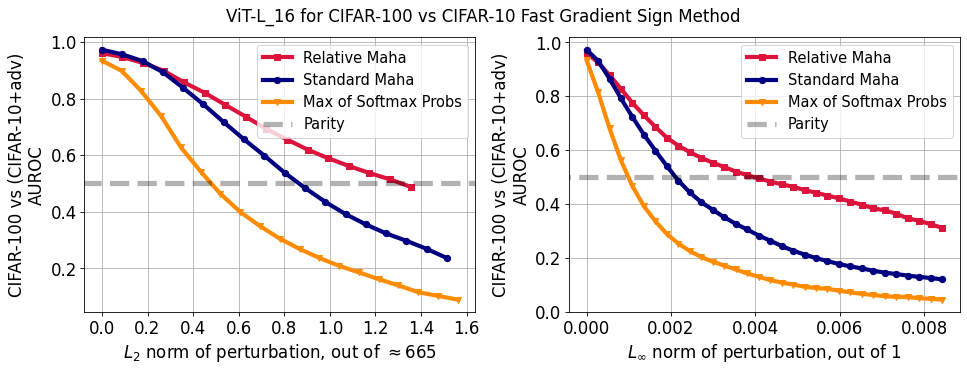

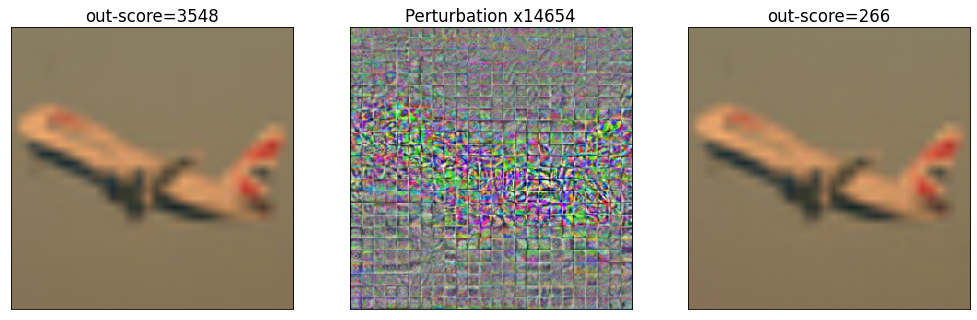

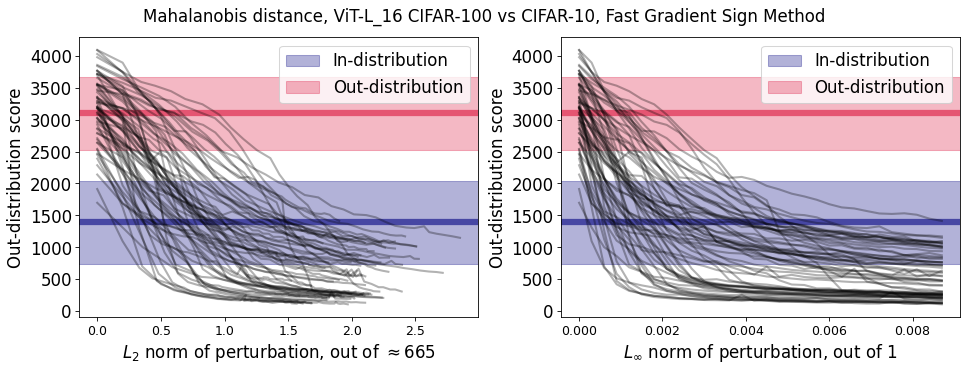

# Imports and loading

In [ ]:
import numpy as np

In [ ]:
![ -d vision_transformer ] 
!pwd

/content


In [ ]:
# Fetch vision_transformer repository.
![ -d vision_transformer ] || git clone --depth=1 https://github.com/google-research/vision_transformer

Cloning into 'vision_transformer'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 37 (delta 4), reused 31 (delta 4), pack-reused 0
Unpacking objects: 100% (37/37), done.


In [ ]:
# Install dependencies.
!pip install -qr vision_transformer/vit_jax/requirements.txt

     |████████████████████████████████| 65 kB 2.6 MB/s 
     |████████████████████████████████| 77 kB 7.4 MB/s 
     |████████████████████████████████| 207 kB 68.2 MB/s 
     |████████████████████████████████| 88 kB 8.9 MB/s 
     |████████████████████████████████| 179.8 MB 75 kB/s 
     |████████████████████████████████| 126 kB 69.0 MB/s 


In [ ]:
!ls vision_transformer/vit_jax/

checkpoint.py		__init__.py	   models_resnet.py  train.py
checkpoint_test.py	input_pipeline.py  models_test.py    train_test.py
configs			main.py		   momentum_clip.py  utils.py
inference_time.py	models_mixer.py    requirements.txt
inference_time_test.py	models.py	   test_utils.py


In [ ]:
# fetch out repository to get the modified models.py file with the pre-logits extraction
!git clone --depth=1 https://github.com/stanislavfort/adversaries_to_OOD_detection

Cloning into 'adversaries_to_OOD_detection'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 5 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (5/5), done.


In [ ]:
!rm vision_transformer/vit_jax/models.py
!cp adversaries_to_OOD_detection/models.py vision_transformer/vit_jax/

In [ ]:
# Import files from repository.

import sys
if './vision_transformer' not in sys.path:
  sys.path.append('./vision_transformer')

%load_ext autoreload
%autoreload 2

from vit_jax import checkpoint
from vit_jax import models
from vit_jax import train
from vit_jax.configs import augreg as augreg_config
from vit_jax.configs import models as models_config

In [ ]:
#to add the prelogits versions
from google.colab import files

files.view('vision_transformer/vit_jax/models.py')

<IPython.core.display.Javascript object>

In [ ]:
!nvidia-smi

Sat Jan 15 08:10:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import glob
import os
import random
import shutil
import time

from absl import logging
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt


# Loading ViT checkpoints from Google Brain repo

### Load a checkpoint

In [ ]:
#selecting a ViT checkpoint
filename = 'L_16-i21k-300ep-lr_0.001-aug_strong1-wd_0.1-do_0.0-sd_0.0--cifar100-steps_2k-lr_0.01-res_384'

tfds_name = filename.split('--')[1].split('-')[0]
model_config = models_config.AUGREG_CONFIGS[filename.split('-')[0]]
resolution = int(filename.split('_')[-1])
path = f'gs://vit_models/augreg/{filename}.npz'

print(f'{tf.io.gfile.stat(path).length / 1024 / 1024:.1f} MiB - {path}')

1159.0 MiB - gs://vit_models/augreg/L_16-i21k-300ep-lr_0.001-aug_strong1-wd_0.1-do_0.0-sd_0.0--cifar100-steps_2k-lr_0.01-res_384.npz


In [ ]:
ds, ds_info = tfds.load(tfds_name, with_info=True,batch_size=128)
ds_info

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar100/3.0.2.incomplete99D20I/cifar100-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar100/3.0.2.incomplete99D20I/cifar100-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar100 downloaded and prepared to /root/tensorflow_datasets/cifar100/3.0.2. Subsequent calls will reuse this data.


tfds.core.DatasetInfo(
    name='cifar100',
    version=3.0.2,
    description='This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs).',
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    features=FeaturesDict({
        'coarse_label': ClassLabel(shape=(), dtype=tf.int64, num_classes=20),
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=100),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000,
    },
    supervised_keys=('image', 'label'),
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {

In [ ]:
# Get a clean model
model = models.VisionTransformer(
    num_classes=ds_info.features['label'].num_classes, **model_config)

In [ ]:
# Load a checkpoint from cloud
# takes a while for a big model
params = checkpoint.load(path)

In [ ]:
# out modified model that outputs pre-logits = embeddings for OOD detection
model_prelogits = models.VisionTransformer_prelogits(
    num_classes=ds_info.features['label'].num_classes, **model_config)

# Getting unaugmented datasets

In [ ]:
def pp(img, sz):
  img = tf.cast(img, float) / 255.0
  img = tf.image.resize(img, [sz, sz])
  return img

In [ ]:
import tensorflow_datasets as tfds 
import tensorflow as tf

def prepare_pure_dataset(ds_in, num_classes,repeats = 1,shuffle=True, batch_size=128):

  ds_in = ds_in.map(lambda d: {"image": pp(d["image"],resolution), "label": d["label"]}, tf.data.experimental.AUTOTUNE)

  ds_in = ds_in.repeat(repeats)
  if shuffle:
    ds_in = ds_in.shuffle(200000)

  ds_in = ds_in.batch(batch_size, drop_remainder=True)

  return ds_in

In [ ]:
batch_size = 128

cifar10_ds_train = prepare_pure_dataset(tfds.load('cifar10', split='train', shuffle_files=False), 10, shuffle=False, batch_size=batch_size)
cifar10_ds_test = prepare_pure_dataset(tfds.load('cifar10', split='test', shuffle_files=False), 10, shuffle=False, batch_size=batch_size)
cifar100_ds_train = prepare_pure_dataset(tfds.load('cifar100', split='train', shuffle_files=False), 100, shuffle=False, batch_size=batch_size)
cifar100_ds_test = prepare_pure_dataset(tfds.load('cifar100', split='test', shuffle_files=False), 100, shuffle=False, batch_size=batch_size)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete0SO7DN/cifar10-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete0SO7DN/cifar10-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [ ]:
#verification
def get_value_spreads_for_dataset(ds_in):
  batch = next(ds_in.as_numpy_iterator())
  images = batch["image"]
  min_now,mean_now,max_now = np.min(images),np.mean(images),np.max(images)
  return min_now,mean_now,max_now

min_now,mean_now,max_now = get_value_spreads_for_dataset(cifar10_ds_train)
print(min_now,mean_now,max_now)

min_now,mean_now,max_now = get_value_spreads_for_dataset(cifar10_ds_test)
print(min_now,mean_now,max_now)

min_now,mean_now,max_now = get_value_spreads_for_dataset(cifar100_ds_train)
print(min_now,mean_now,max_now)

min_now,mean_now,max_now = get_value_spreads_for_dataset(cifar100_ds_test)
print(min_now,mean_now,max_now)


0.0 0.47670496 1.0
0.0 0.4786665 1.0
0.0 0.5022136 1.0
0.0 0.47278368 1.0


# Prelogits extraction

## Extractor

In [ ]:
import time

def standalone_get_prelogits(params, ds_in,image_count=50000):
  """Returns prelogits on the dataset"""
  prelogits_all = []
  logits_all = []
  labels_all = []

  ts = []

  t1 = time.time()

  for batch in ds_in.as_numpy_iterator():

    prelogits = model_prelogits.apply({'params': params}, batch["image"], train=False)
    logits = model.apply({'params': params}, batch["image"], train=False)

    prelogits_all.append(prelogits)
    logits_all.append(logits)
    labels_all.append(batch["label"])

    count_so_far = len(np.concatenate(prelogits_all,axis=0))

    t2 = time.time()
    ts.append(t2-t1)
    t1 = time.time()

    t_rem = (image_count-count_so_far)*np.mean(ts)/batch_size

    print("Images done="+str(count_so_far)+" time remaining="+str(int(t_rem))+"s")

    if count_so_far >= image_count:
      break #early break for subsets of data

  return np.concatenate(prelogits_all,axis=0), np.concatenate(logits_all,axis=0), np.concatenate(labels_all,axis=0)

## Getting the prelogits

The full datasets extraction will take some time. Taking a 1/10 subset is sufficient to show the effectivness of the Mahalanobis distance and Relative Mahalanobis distance as compared to the Maximum over Softmax Probabilities and runs in 20 mins on a single V100 GPU in a Colab (probably slower on a P100).

In [ ]:
# choosing the subsets of the train and test set to extract embeddings for
N_train = 5000
N_test = 1000

assert N_train <= 50000
assert N_test <= 10000

### CIFAR-10 test (1.5 minutes)

In [ ]:
cifar10_test_prelogits, cifar10_test_logits, cifar10_test_labels = standalone_get_prelogits(
    params, 
    cifar10_ds_test, 
    image_count=N_test
    )

Images done=128 time remaining=196s
Images done=256 time remaining=116s
Images done=384 time remaining=81s
Images done=512 time remaining=59s
Images done=640 time remaining=41s
Images done=768 time remaining=25s
Images done=896 time remaining=11s
Images done=1024 time remaining=-2s


### CIFAR-100 test (1.5 minutes)

In [ ]:
cifar100_test_prelogits, cifar100_test_logits, cifar100_test_labels = standalone_get_prelogits(
    params, 
    cifar100_ds_test, 
    image_count=N_test
    )

Images done=128 time remaining=76s
Images done=256 time remaining=65s
Images done=384 time remaining=53s
Images done=512 time remaining=42s
Images done=640 time remaining=31s
Images done=768 time remaining=20s
Images done=896 time remaining=9s
Images done=1024 time remaining=-2s


### CIFAR-10 train (8 minutes)

In [ ]:
cifar10_train_prelogits, cifar10_train_logits, cifar10_train_labels = standalone_get_prelogits(
    params, 
    cifar10_ds_train, 
    image_count=N_train
    )

Images done=128 time remaining=432s
Images done=256 time remaining=416s
Images done=384 time remaining=404s
Images done=512 time remaining=392s
Images done=640 time remaining=380s
Images done=768 time remaining=369s
Images done=896 time remaining=358s
Images done=1024 time remaining=346s
Images done=1152 time remaining=335s
Images done=1280 time remaining=324s
Images done=1408 time remaining=313s
Images done=1536 time remaining=301s
Images done=1664 time remaining=291s
Images done=1792 time remaining=279s
Images done=1920 time remaining=268s
Images done=2048 time remaining=257s
Images done=2176 time remaining=246s
Images done=2304 time remaining=235s
Images done=2432 time remaining=224s
Images done=2560 time remaining=212s
Images done=2688 time remaining=201s
Images done=2816 time remaining=190s
Images done=2944 time remaining=179s
Images done=3072 time remaining=168s
Images done=3200 time remaining=157s
Images done=3328 time remaining=145s
Images done=3456 time remaining=134s
Images d

### CIFAR-100 train (8 minutes)

In [ ]:
cifar100_train_prelogits, cifar100_train_logits, cifar100_train_labels = standalone_get_prelogits(
    params, 
    cifar100_ds_train, 
    image_count=N_train
    )

Images done=128 time remaining=435s
Images done=256 time remaining=417s
Images done=384 time remaining=403s
Images done=512 time remaining=391s
Images done=640 time remaining=380s
Images done=768 time remaining=368s
Images done=896 time remaining=357s
Images done=1024 time remaining=346s
Images done=1152 time remaining=335s
Images done=1280 time remaining=324s
Images done=1408 time remaining=313s
Images done=1536 time remaining=301s
Images done=1664 time remaining=290s
Images done=1792 time remaining=279s
Images done=1920 time remaining=268s
Images done=2048 time remaining=257s
Images done=2176 time remaining=246s
Images done=2304 time remaining=235s
Images done=2432 time remaining=223s
Images done=2560 time remaining=212s
Images done=2688 time remaining=201s
Images done=2816 time remaining=190s
Images done=2944 time remaining=179s
Images done=3072 time remaining=168s
Images done=3200 time remaining=156s
Images done=3328 time remaining=145s
Images done=3456 time remaining=134s
Images d

## Accuracies

In [ ]:
# checking the accuracy on CIFAR-100

finetune_test_acc = np.mean(
    np.argmax(cifar100_test_logits,axis=-1) == cifar100_test_labels
    )

print("CIFAR-100 test accuracy = "+str(finetune_test_acc))

finetune_train_acc = np.mean(
    np.argmax(cifar100_train_logits,axis=-1) == cifar100_train_labels
    )

print("CIFAR-100 train accuracy = "+str(finetune_train_acc))

CIFAR-100 test accuracy = 0.943359375
CIFAR-100 train accuracy = 0.9728515625


# Computing the near-OOD CIFAR-100 $\to$ CIFAR-10 AUROC

In [ ]:
cifar10_test_embeds = cifar10_test_prelogits
cifar10_y_test = cifar10_test_labels
cifar10_test_preds = cifar10_test_logits

cifar100_test_embeds = cifar100_test_prelogits
cifar100_y_test = cifar100_test_labels
cifar100_test_preds = cifar100_test_logits

cifar10_train_embeds = cifar10_train_prelogits
cifar10_y_train = cifar10_train_labels
cifar10_train_preds = cifar10_train_logits

cifar100_train_embeds = cifar100_train_prelogits
cifar100_y_train = cifar100_train_labels
cifar100_train_preds = cifar100_train_logits

## Computing Mahalanobis means and covariances

In [ ]:
def np_softmax(zs):
  exps = np.exp(zs-np.max(zs))
  return exps/np.sum(exps,axis=-1,keepdims=True)

In [ ]:
from sklearn.metrics import roc_auc_score

def maha_distance(xs,cov_inv_in,mean_in,norm_type=None):
  diffs = xs - mean_in.reshape([1,-1])

  second_powers = np.matmul(diffs,cov_inv_in)*diffs

  if norm_type in [None,"L2"]:
    return np.sum(second_powers,axis=1)
  elif norm_type in ["L1"]:
    return np.sum(np.sqrt(np.abs(second_powers)),axis=1)
  elif norm_type in ["Linfty"]:
    return np.max(second_powers,axis=1)

def get_scores(
    indist_train_embeds_in,
    indist_train_labels_in,
    indist_test_embeds_in,
    outdist_test_embeds_in,
    subtract_mean = True,
    normalize_to_unity = True,
    subtract_train_distance = True,
    indist_classes = 100,
    norm_name = "L2",
    ):
  
  # storing the replication results
  maha_intermediate_dict = dict()
  
  description = ""
  
  all_train_mean = np.mean(indist_train_embeds_in,axis=0,keepdims=True)

  indist_train_embeds_in_touse = indist_train_embeds_in
  indist_test_embeds_in_touse = indist_test_embeds_in
  outdist_test_embeds_in_touse = outdist_test_embeds_in

  if subtract_mean:
    indist_train_embeds_in_touse -= all_train_mean
    indist_test_embeds_in_touse -= all_train_mean
    outdist_test_embeds_in_touse -= all_train_mean
    description = description+" subtract mean,"

  if normalize_to_unity:
    indist_train_embeds_in_touse = indist_train_embeds_in_touse / np.linalg.norm(indist_train_embeds_in_touse,axis=1,keepdims=True)
    indist_test_embeds_in_touse = indist_test_embeds_in_touse / np.linalg.norm(indist_test_embeds_in_touse,axis=1,keepdims=True)
    outdist_test_embeds_in_touse = outdist_test_embeds_in_touse / np.linalg.norm(outdist_test_embeds_in_touse,axis=1,keepdims=True)
    description = description+" unit norm,"

  #full train single fit
  mean = np.mean(indist_train_embeds_in_touse,axis=0)
  cov = np.cov((indist_train_embeds_in_touse-(mean.reshape([1,-1]))).T)

  eps = 1e-8
  cov_inv = np.linalg.inv(cov)

  #getting per class means and covariances
  class_means = []
  class_cov_invs = []
  class_covs = []
  for c in range(indist_classes):

    mean_now = np.mean(indist_train_embeds_in_touse[indist_train_labels_in == c],axis=0)

    cov_now = np.cov((indist_train_embeds_in_touse[indist_train_labels_in == c]-(mean_now.reshape([1,-1]))).T)
    class_covs.append(cov_now)
    # print(c)

    eps = 1e-8
    cov_inv_now = np.linalg.inv(cov_now)

    class_cov_invs.append(cov_inv_now)
    class_means.append(mean_now)

  #the average covariance for class specific
  class_cov_invs = [np.linalg.inv(np.mean(np.stack(class_covs,axis=0),axis=0))]*len(class_covs)

  maha_intermediate_dict["class_cov_invs"] = class_cov_invs
  maha_intermediate_dict["class_means"] = class_means
  maha_intermediate_dict["cov_inv"] = cov_inv
  maha_intermediate_dict["mean"] = mean

  out_totrain = maha_distance(outdist_test_embeds_in_touse,cov_inv,mean,norm_name)
  in_totrain = maha_distance(indist_test_embeds_in_touse,cov_inv,mean,norm_name)

  out_totrainclasses = [maha_distance(outdist_test_embeds_in_touse,class_cov_invs[c],class_means[c],norm_name) for c in range(indist_classes)]
  in_totrainclasses = [maha_distance(indist_test_embeds_in_touse,class_cov_invs[c],class_means[c],norm_name) for c in range(indist_classes)]

  out_scores = np.min(np.stack(out_totrainclasses,axis=0),axis=0)
  in_scores = np.min(np.stack(in_totrainclasses,axis=0),axis=0)

  if subtract_train_distance:
    out_scores = out_scores - out_totrain
    in_scores = in_scores - in_totrain


  onehots = np.array([1]*len(out_scores) + [0]*len(in_scores))
  scores = np.concatenate([out_scores,in_scores],axis=0)

  return onehots, scores, description, maha_intermediate_dict

In [ ]:
from sklearn.metrics import roc_auc_score

def get_auroc(onehots,scores,make_plot = True,add_to_title=None,swap_classes=False):

  auroc = roc_auc_score(onehots, scores)

  to_replot_dict = dict()

  if swap_classes == False:
    out_scores,in_scores = scores[onehots==0], scores[onehots==1] 
  else:
    out_scores,in_scores = scores[onehots==1], scores[onehots==0] 

  if make_plot:
    plt.figure(figsize = (5.5,3),dpi=100)

    if add_to_title is not None:
      plt.title(add_to_title+" AUROC="+str(float(auroc*100))[:6]+"%",fontsize=14)
    else:
      plt.title(" AUROC="+str(float(auroc*100))[:6]+"%",fontsize=14)


  vals,bins = np.histogram(out_scores,bins = 51)
  bin_centers = (bins[1:]+bins[:-1])/2.0

  if make_plot:
    plt.plot(bin_centers,vals,linewidth=4,color="navy",marker="",label="in test")
    plt.fill_between(bin_centers,vals,[0]*len(vals),color="navy",alpha=0.3)

  to_replot_dict["out_bin_centers"] = bin_centers
  to_replot_dict["out_vals"] = vals

  vals,bins = np.histogram(in_scores,bins = 51)
  bin_centers = (bins[1:]+bins[:-1])/2.0

  if make_plot:
    plt.plot(bin_centers,vals,linewidth=4,color="crimson",marker="",label="out test")
    plt.fill_between(bin_centers,vals,[0]*len(vals),color="crimson",alpha=0.3)

  to_replot_dict["in_bin_centers"] = bin_centers
  to_replot_dict["in_vals"] = vals

  if make_plot:
    plt.xlabel("Score",fontsize=14)
    plt.ylabel("Count",fontsize=14)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.ylim([0,None])

    plt.legend(fontsize = 14)

    plt.tight_layout()
    plt.show()

  return auroc,to_replot_dict

## Standard Mahalanobis distance

In [ ]:
onehots, scores, description, maha_intermediate_dict = get_scores(
        np.array(cifar100_train_embeds)[:,:],
        cifar100_y_train,
        np.array(cifar100_test_embeds)[:,:],
        np.array(cifar10_test_embeds)[:,:],
        indist_classes=100,
        subtract_mean = False,
        normalize_to_unity = False,
        subtract_train_distance = False,
    )


In [ ]:
class_means = maha_intermediate_dict["class_means"]
class_cov_invs = maha_intermediate_dict["class_cov_invs"]

indist_test_embeds = cifar100_test_embeds

outdist_test_embeds = cifar10_test_embeds

indist_dists = []
for c in range(100):
  indist_offset_now = indist_test_embeds - class_means[c].reshape([1,-1])
  maha_dists_now = np.sum(np.matmul(indist_offset_now,class_cov_invs[c])*indist_offset_now,axis=1)
  indist_dists.append(maha_dists_now)

outdist_dists = []
for c in range(100):
  outdist_offset_now = outdist_test_embeds - class_means[c].reshape([1,-1])
  maha_dists_now = np.sum(np.matmul(outdist_offset_now,class_cov_invs[c])*outdist_offset_now,axis=1)
  outdist_dists.append(maha_dists_now)



In [ ]:
indist_dists_byclass = np.stack(indist_dists,axis=1)
indist_min = np.min(indist_dists_byclass,axis=1)

outdist_dists_byclass = np.stack(outdist_dists,axis=1)
outdist_min = np.min(outdist_dists_byclass,axis=1)

onehots = np.array([1]*len(outdist_min) + [0]*len(indist_min))
scores = np.concatenate([outdist_min,indist_min],axis=0)

# for making the plot for adversaries later
maha_outdist_scores = outdist_min
maha_indist_scores = indist_min

In [ ]:
print("CIFAR-100 score = "+str(np.mean(indist_min))+"+-"+str(np.std(indist_min)))
print("CIFAR-10 score = "+str(np.mean(outdist_min))+"+-"+str(np.std(outdist_min)))

CIFAR-100 score = 1391.4418850563839+-649.6479017258216
CIFAR-10 score = 3097.3693140415235+-569.8437096871896


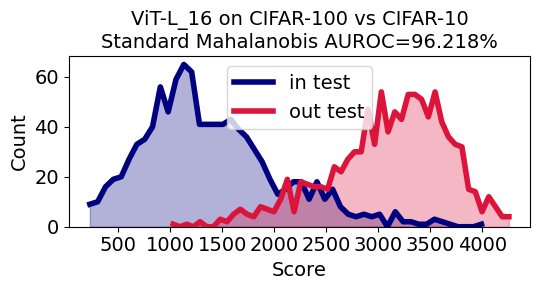

In [ ]:
auroc, to_replot_dict = get_auroc(
    onehots, 
    scores, 
    make_plot=True,
    add_to_title="ViT-L_16 on CIFAR-100 vs CIFAR-10\nStandard Mahalanobis"
    )

maha_auroc = auroc

## Relative Mahalanobis distance

In [ ]:
train_mean = maha_intermediate_dict["mean"]
train_cov_inv = maha_intermediate_dict["cov_inv"]

In [ ]:
onehots, scores, description, maha_intermediate_dict = get_scores(
        np.array(cifar100_train_embeds)[:,:],
        cifar100_y_train,
        np.array(cifar100_test_embeds)[:,:],
        np.array(cifar10_test_embeds)[:,:],
        indist_classes=100,
        subtract_mean = False,
        normalize_to_unity = False,
        subtract_train_distance = True,
    )



In [ ]:
indist_dists_byclass = np.stack(indist_dists,axis=1)
indist_min = np.min(indist_dists_byclass,axis=1)

outdist_dists_byclass = np.stack(outdist_dists,axis=1)
outdist_min = np.min(outdist_dists_byclass,axis=1)

onehots = np.array([1]*len(outdist_min) + [0]*len(indist_min))
scores = np.concatenate([outdist_min,indist_min],axis=0)

In [ ]:
indist_dists_byclass = np.stack(indist_dists,axis=1)
indist_min = np.min(indist_dists_byclass,axis=1)

outdist_dists_byclass = np.stack(outdist_dists,axis=1)
outdist_min = np.min(outdist_dists_byclass,axis=1)

prelogits = indist_test_embeds
offset_now = prelogits - np.array(train_mean).reshape([1,-1]).astype(np.float64)
offset_now = offset_now.astype(np.float64)
train_maha_dist = np.einsum("ai,ij->aj",offset_now,np.array(train_cov_inv).astype(np.float64))
train_maha_dist = np.einsum("aj,aj->a",train_maha_dist,offset_now)
indist_train_dist = train_maha_dist

prelogits = outdist_test_embeds
offset_now = prelogits - np.array(train_mean).reshape([1,-1]).astype(np.float64)
offset_now = offset_now.astype(np.float64)
train_maha_dist = np.einsum("ai,ij->aj",offset_now,np.array(train_cov_inv).astype(np.float64))
train_maha_dist = np.einsum("aj,aj->a",train_maha_dist,offset_now)
outdist_train_dist = train_maha_dist

outdist_scores = outdist_min-outdist_train_dist
indist_scores = indist_min-indist_train_dist

# for making the plot for adversaries later
ratio_outdist_scores = outdist_scores
ratio_indist_scores = indist_scores

onehots = np.array([1]*len(outdist_min) + [0]*len(indist_min))
scores = np.concatenate([outdist_scores,indist_scores],axis=0)

In [ ]:
print("CIFAR-100 score = "+str(np.mean(indist_scores))+"+-"+str(np.std(indist_scores)))
print("CIFAR-10 score = "+str(np.mean(outdist_scores))+"+-"+str(np.std(outdist_scores)))

CIFAR-100 score = 53.70648706882346+-140.7992890457364
CIFAR-10 score = 479.0666854535716+-131.749445282126


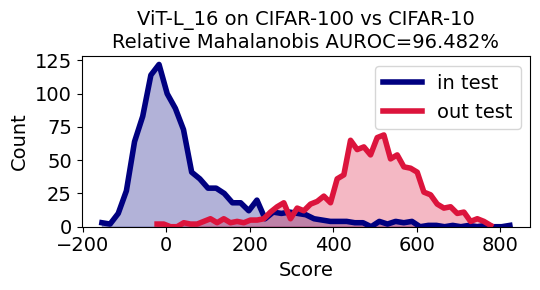

In [ ]:
auroc, to_replot_dict = get_auroc(
    onehots, 
    scores, 
    make_plot=True,
    add_to_title="ViT-L_16 on CIFAR-100 vs CIFAR-10\nRelative Mahalanobis"
    )

ratio_auroc = auroc

## Max of Softmax Probabilities score

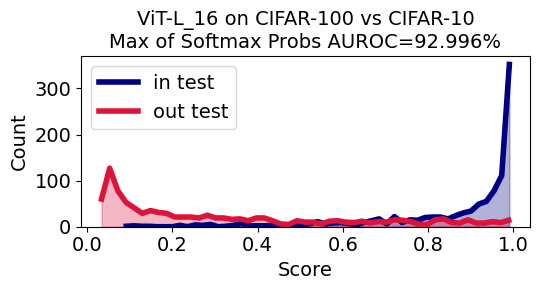

In [ ]:
scores = np.array(
    np.concatenate([
     np.max(np_softmax(cifar100_test_logits),axis=-1),
     np.max(np_softmax(cifar10_test_logits),axis=-1),
    ],axis=0)
)

# for making the plot for adversaries later
MSP_outdist_scores = np.max(np_softmax(cifar10_test_logits),axis=-1)
MSP_indist_scores = np.max(np_softmax(cifar100_test_logits),axis=-1)

onehots = np.array(
    [1]*len(cifar100_test_logits)+[0]*len(cifar10_test_logits)
)

auroc, to_replot_dict = get_auroc(
    onehots, 
    scores, 
    make_plot=True,
    add_to_title="ViT-L_16 on CIFAR-100 vs CIFAR-10\nMax of Softmax Probs",
    swap_classes=True,
    )

MSP_auroc = auroc

# Adversarial examples to OOD score

## Score and grad utils

In [121]:
import jax.numpy as jnp
import jax

from jax.config import config
config.update("jax_enable_x64", True)

In [122]:
def get_score(
    image,
    params,
    use_ratio=False, #to turn Maha ratio on and off
    ):

  min_scores_list = []

  assert image.shape[0] == 1

  prelogits = model_prelogits.apply({'params': params}, image, train=False)

  class_means = maha_intermediate_dict["class_means"]
  class_cov_invs = maha_intermediate_dict["class_cov_invs"]
  train_mean = maha_intermediate_dict["mean"]
  train_cov_inv = maha_intermediate_dict["cov_inv"]

  class_cov_invs = [M for M in class_cov_invs]

  class_dists = []
  for c in range(100):
    offset_now = prelogits - jnp.array(class_means[c]).reshape([1,-1]).astype(jnp.float64)
    offset_now = offset_now.astype(jnp.float64)
    
    maha_dists_now = jnp.einsum("ai,ij->aj",offset_now,jnp.array(class_cov_invs[c]).astype(jnp.float64))
    maha_dists_now = jnp.einsum("aj,aj->a",maha_dists_now,offset_now)
    
    class_dists.append(maha_dists_now)

  class_dists_np = jnp.stack(jnp.array(class_dists),axis=1)

  # distance to the train set
  offset_now = prelogits - jnp.array(train_mean).reshape([1,-1]).astype(jnp.float64)
  offset_now = offset_now.astype(jnp.float64)
  train_maha_dist = jnp.einsum("ai,ij->aj",offset_now,jnp.array(train_cov_inv).astype(jnp.float64))
  train_maha_dist = jnp.einsum("aj,aj->a",train_maha_dist,offset_now)

  min_scores = jnp.min(class_dists_np)

  if use_ratio == False:
    return jnp.mean(min_scores)
  else:
    return jnp.mean(min_scores - jnp.mean(train_maha_dist))

  return None

In [123]:
def get_input_grad(image,params,use_ratio=False):
  return jax.grad(
      lambda image_in: get_score(image_in,params,use_ratio=use_ratio)
  )(image)

In [124]:
get_score_jit = jax.jit(get_score,static_argnames=["use_ratio"])
get_input_grad_jit = jax.jit(get_input_grad,static_argnames=["use_ratio"])

## Adversary finding fn

In [125]:
def find_adversary(
    start_image,
    label_now,
    steps=30,
    LR=3e-4,
    gradient_signs_only=True,
    first_gradient_only=False,
    top_k_pixels=None,
    target_score=None,
    use_ratio=False,
    verbose=1,
):


  image_now = start_image
  image_start = image_now

  scores_list = []
  images_list = []
  L2_perturbation_list = []
  Linfty_perturbation_list = []

  for it in range(steps):

    score_now = get_score_jit(
        image_now,
        params,
        use_ratio=use_ratio,
        )
    
    #early stopping
    if (target_score is not None) and (score_now < target_score):
      break
    
    images_list.append(image_now)

    scores_list.append(score_now)
    L2_perturbation_list.append(np.linalg.norm(image_now - image_start))
    Linfty_perturbation_list.append(np.max(np.abs(image_now - image_start)))
    
    if it == 0:
      score_start = score_now
    
    if it % verbose == 0:
      print("image="+str(i)+" step="+str(it)+" OOD score="+str(score_now))
    
    if ((first_gradient_only == False) or (it==0)): 
      image_grad_now = get_input_grad_jit(
          image_now,
          params,
          use_ratio=use_ratio,
          )
    
    if gradient_signs_only:
      image_grad_now = ((image_grad_now>0.0)*2.0-1.0)


    image_now = image_now - LR*image_grad_now



  return image_start, scores_list, images_list, L2_perturbation_list, Linfty_perturbation_list


## Standard Mahalanobis distance adversaries

### An example image finding

In [126]:
batch_now = next(cifar10_ds_test.as_numpy_iterator())
i = 34
image_now = batch_now["image"][i:i+1]
label_now = batch_now["image"][i:i+1]

image_start, scores_list, images_list, L2_perturbation_list, Linfty_perturbation_list = find_adversary(
    image_now,
    label_now,
    steps=30,
    LR=3e-4,
    gradient_signs_only=True,
    first_gradient_only=False,
    top_k_pixels=None,
    target_score=None,
    use_ratio=False,
)

image=34 step=0 OOD score=3548.858340873975
image=34 step=1 OOD score=3350.757364414865
image=34 step=2 OOD score=3131.355121140601
image=34 step=3 OOD score=2976.43370124558
image=34 step=4 OOD score=2762.6379328661133
image=34 step=5 OOD score=2289.4666216718033
image=34 step=6 OOD score=1657.4622090877965
image=34 step=7 OOD score=1269.1329166714568
image=34 step=8 OOD score=1069.5496889717178
image=34 step=9 OOD score=947.5074946680106
image=34 step=10 OOD score=871.0585695016198
image=34 step=11 OOD score=763.7790680532344
image=34 step=12 OOD score=636.2672075005248
image=34 step=13 OOD score=467.409484237025
image=34 step=14 OOD score=401.25169353804085
image=34 step=15 OOD score=380.5657078103395
image=34 step=16 OOD score=370.59029302190174
image=34 step=17 OOD score=358.5444304259727
image=34 step=18 OOD score=346.29260484757833
image=34 step=19 OOD score=333.7634101593867
image=34 step=20 OOD score=336.0446863650577
image=34 step=21 OOD score=322.8380288926419
image=34 step=

### A nice plot

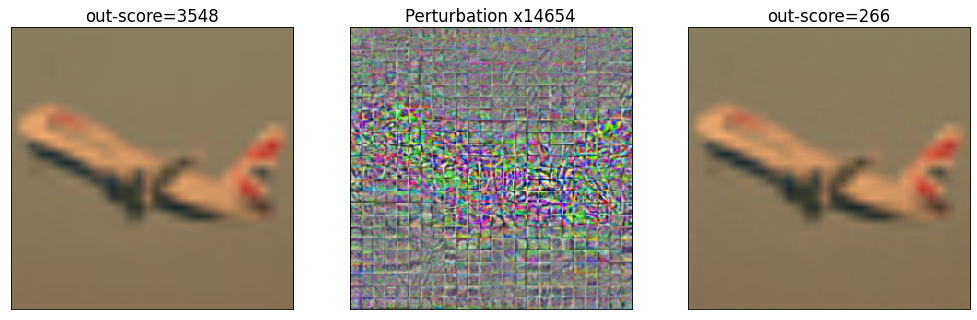

In [127]:
plt.figure(figsize=(3*5.5,5),dpi=75)

plt.subplot(1,3,1)
plt.title("out-score="+str(int(scores_list[0])),fontsize=16)
plt.imshow(np.round((image_start[0])*255).astype(np.uint8))
plt.xticks([],[])
plt.yticks([],[])

plt.subplot(1,3,2)

im_diff = images_list[-1][0]-image_start[0]

diff_range = np.max(im_diff) - np.min(im_diff)

plt.title("Perturbation x"+str(int(255.0/diff_range)),fontsize=16)

im_diff = im_diff -  np.min(im_diff)
im_diff = im_diff/np.max(im_diff)*255

plt.imshow(np.round(im_diff).astype(np.uint8))
plt.xticks([],[])
plt.yticks([],[])

plt.subplot(1,3,3)
plt.title("out-score="+str(int(scores_list[-1])),fontsize=16)
plt.imshow(np.round((images_list[-1][0])*255).astype(np.uint8))
plt.xticks([],[])
plt.yticks([],[])

plt.show()

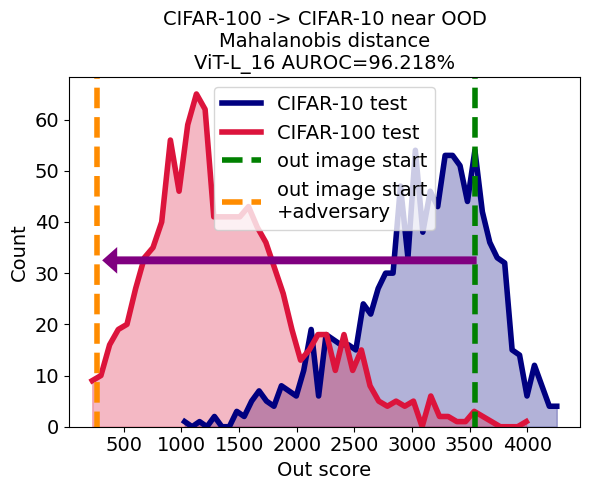

In [128]:
plt.figure(figsize = (6,5),dpi=100)

model_name = "ViT-L_16"

plt.title("CIFAR-100 -> CIFAR-10 near OOD\nMahalanobis distance\n"+model_name+" AUROC="+str(float(maha_auroc*100))[:6]+"%",fontsize=14)

vals,bins = np.histogram(maha_outdist_scores,bins = 51)
bin_centers = (bins[1:]+bins[:-1])/2.0

plt.plot(bin_centers,vals,linewidth=4,color="navy",marker="",label="CIFAR-10 test")
plt.fill_between(bin_centers,vals,[0]*len(vals),color="navy",alpha=0.3)

vals,bins = np.histogram(maha_indist_scores,bins = 51)
bin_centers = (bins[1:]+bins[:-1])/2.0

plt.plot(bin_centers,vals,linewidth=4,color="crimson",marker="",label="CIFAR-100 test")
plt.fill_between(bin_centers,vals,[0]*len(vals),color="crimson",alpha=0.3)

plt.xlabel("Out score",fontsize=14)
plt.ylabel("Count",fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ylim = plt.gca().get_ylim()

plt.plot([scores_list[0]]*2,[-100,10000],color="green",linewidth=4,
         label="out image start",linestyle="--")

plt.plot([scores_list[-1]]*2,[-100,10000],color="darkorange",linewidth=4,
         label="out image start\n+adversary",linestyle="--")

plt.arrow(scores_list[0],np.mean(ylim),(scores_list[-1]-scores_list[0])*0.95,0,
          linewidth=2,color="purple",width=1,head_width=4,head_length=100,zorder=9)

plt.ylim([0,ylim[-1]])

plt.legend(fontsize = 14)

plt.tight_layout()
plt.show()

### Many images at once

In [129]:
images_count = 64 #for a faster run you can generate a small amount

steps = 30
LR = 3e-4

batch_now = next(cifar10_ds_test.as_numpy_iterator())

scores_grid = np.zeros((images_count,steps))*float("NaN")
L2_perturbation_sizes = np.zeros((images_count,steps))*float("NaN")
Linfty_perturbation_sizes = np.zeros((images_count,steps))*float("NaN")

times = []

for i in range(images_count):

  t1_now = time.time()

  image_now = batch_now["image"][i:i+1]
  label_now = batch_now["image"][i:i+1]

  image_start, scores_list, images_list, L2_perturbation_list, Linfty_perturbation_list = find_adversary(
      image_now,
      label_now,
      steps=steps,
      LR=LR,
      gradient_signs_only=True,
      first_gradient_only=False,
      top_k_pixels=None,
      target_score=None,
      use_ratio=False,
      verbose=steps-1,
  )

  scores_grid[i] = np.array(scores_list)
  L2_perturbation_sizes[i] = np.array(L2_perturbation_list)
  Linfty_perturbation_sizes[i] = np.array(Linfty_perturbation_list)

  t2_now = time.time()
  
  times.append(t2_now-t1_now)
  t_rem = np.mean(times)*images_count - np.sum(times)
  print("t_remaining = "+str(int(t_rem))+" seconds")


image=0 step=0 OOD score=4087.9574811351486
image=0 step=29 OOD score=556.495695407968
t_remaining = 1012 seconds
image=1 step=0 OOD score=4089.907424263656
image=1 step=29 OOD score=938.8300682669505
t_remaining = 996 seconds
image=2 step=0 OOD score=2972.663055904093
image=2 step=29 OOD score=874.6672700543495
t_remaining = 979 seconds
image=3 step=0 OOD score=3029.8774056648836
image=3 step=29 OOD score=260.0807385306107
t_remaining = 964 seconds
image=4 step=0 OOD score=3425.0720362309366
image=4 step=29 OOD score=207.49126427061856
t_remaining = 948 seconds
image=5 step=0 OOD score=3837.6894323453307
image=5 step=29 OOD score=307.6934682033607
t_remaining = 931 seconds
image=6 step=0 OOD score=3187.200446659699
image=6 step=29 OOD score=545.0086557661925
t_remaining = 915 seconds
image=7 step=0 OOD score=3762.689052452799
image=7 step=29 OOD score=269.8340204164015
t_remaining = 898 seconds
image=8 step=0 OOD score=2919.4681466212496
image=8 step=29 OOD score=129.8691995459376
t_r

### Score vs perturbation norm

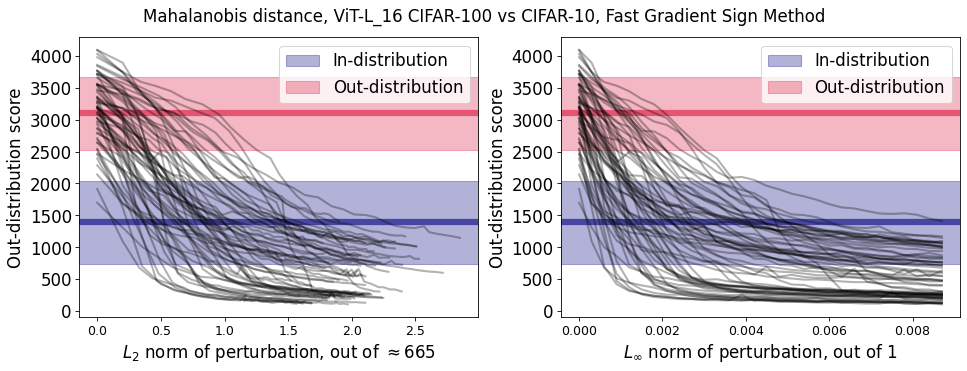

In [130]:
plt.figure(figsize=(2*6.5,5),dpi=75)
plt.suptitle("Mahalanobis distance, "+model_name+" CIFAR-100 vs CIFAR-10, Fast Gradient Sign Method",fontsize=16)

plt.subplot(1,2,1)

for i in range(images_count):
  if True:
    plt.plot(L2_perturbation_sizes[i],scores_grid[i],linewidth=2,color="black",
           marker="",alpha=0.3,zorder=100)

plt.xticks(fontsize=12)
plt.yticks(fontsize=16)

indist_mean = np.mean(maha_indist_scores)
indist_std = np.std(maha_indist_scores)

xlim = plt.gca().get_xlim()

x_range = [
           np.min(L2_perturbation_sizes[~np.isnan(L2_perturbation_sizes)])-100,
           np.max(L2_perturbation_sizes[~np.isnan(L2_perturbation_sizes)])+100
]

plt.plot(x_range,[indist_mean]*2,linewidth=6,alpha=0.6,color="navy")
plt.fill_between(x_range,
                 [indist_mean-indist_std]*2,
                 [indist_mean+indist_std]*2,
                 alpha=0.3,color="navy",label="In-distribution")


outdist_mean = np.mean(maha_outdist_scores)
outdist_std = np.std(maha_outdist_scores)

plt.plot(x_range,[outdist_mean]*2,linewidth=6,alpha=0.6,color="crimson")
plt.fill_between(x_range,
                 [outdist_mean-outdist_std]*2,
                 [outdist_mean+outdist_std]*2,
                 alpha=0.3,color="crimson",label="Out-distribution")

plt.xlim(xlim)

plt.legend(fontsize=16)

plt.xlabel("$L_2$ norm of perturbation, out of $\\approx$665",fontsize=16)
plt.ylabel("Out-distribution score",fontsize=16)


plt.subplot(1,2,2)

for i in range(images_count):
  if True:
    plt.plot(Linfty_perturbation_sizes[i],scores_grid[i],linewidth=2,color="black",
           marker="",alpha=0.3,zorder=100)

plt.xticks(fontsize=12)
plt.yticks(fontsize=16)

indist_mean = np.mean(maha_indist_scores)
indist_std = np.std(maha_indist_scores)

xlim = plt.gca().get_xlim()

x_range = [
           np.min(Linfty_perturbation_sizes[~np.isnan(Linfty_perturbation_sizes)])-100,
           np.max(Linfty_perturbation_sizes[~np.isnan(Linfty_perturbation_sizes)])+100
]

plt.plot(x_range,[indist_mean]*2,linewidth=6,alpha=0.6,color="navy")
plt.fill_between(x_range,
                 [indist_mean-indist_std]*2,
                 [indist_mean+indist_std]*2,
                 alpha=0.3,color="navy",label="In-distribution")


outdist_mean = np.mean(maha_outdist_scores)
outdist_std = np.std(maha_outdist_scores)

plt.plot(x_range,[outdist_mean]*2,linewidth=6,alpha=0.6,color="crimson")
plt.fill_between(x_range,
                 [outdist_mean-outdist_std]*2,
                 [outdist_mean+outdist_std]*2,
                 alpha=0.3,color="crimson",label="Out-distribution")

plt.xlim(xlim)

plt.legend(fontsize=16)

plt.xlabel("$L_\infty$ norm of perturbation, out of 1",fontsize=16)
plt.ylabel("Out-distribution score",fontsize=16)

plt.tight_layout()
plt.subplots_adjust(top=0.9)

plt.show()

### Getting AUROCs

In [131]:
auroc_list = []
for j in range(steps):

  bools = ~np.isnan(scores_grid[:,j])
  # print(np.sum(bools),len(bools))

  onehots = np.array([1]*len(scores_grid[:,j][bools]) + [0]*len(maha_indist_scores[:]))
  scores = np.concatenate([scores_grid[:,j][bools],maha_indist_scores[:]],axis=0)

  auroc, _ = get_auroc(onehots, scores, make_plot=False)

  auroc_list.append(auroc)

### Interpolating $L_2$ perturbations

In [132]:
import matplotlib.pyplot as plt
from scipy import interpolate

L2_to_score_interpolated_fns = []

for i in range(len(scores_grid)):
  x_now = L2_perturbation_sizes[i]
  y_now = scores_grid[i]

  f_now = interpolate.interp1d(x_now, y_now)
  L2_to_score_interpolated_fns.append(f_now)

In [133]:
L2_values_to_scan = np.linspace(
    np.min(L2_perturbation_sizes),
    np.max(L2_perturbation_sizes),
    33
)

collected_aurocs = []

indist_scores = maha_indist_scores

for i,L2_now in enumerate(L2_values_to_scan):

  bools_morethanmin = L2_now >= np.min(L2_perturbation_sizes,axis=1) 
  bools_lessthanmax = L2_now <= np.max(L2_perturbation_sizes,axis=1) 
  bools = np.logical_and(bools_morethanmin,bools_lessthanmax)

  if np.sum(~bools) == 0: # not missing any images

    scores_selected = [f_now(L2_now) for (i,f_now) in enumerate(L2_to_score_interpolated_fns) if bools[i]]

    onehots = np.array([1]*len(scores_selected) + [0]*len(indist_scores[:]))
    scores = np.concatenate([scores_selected,indist_scores[:]],axis=0)

    auroc,_ = get_auroc(onehots, scores, make_plot=False)

  else:
    auroc = float("NaN")

  collected_aurocs.append(auroc)

### Plotting AUROC vs $L_2$ norm

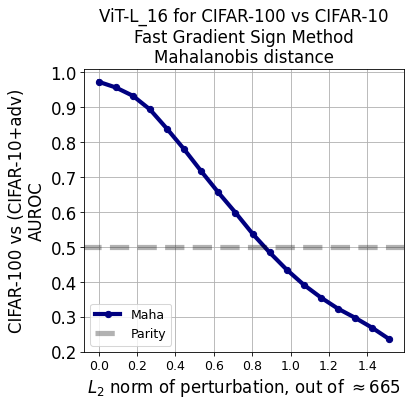

In [134]:
plt.figure(figsize=(5.5,5),dpi=75)
plt.title(model_name+
          " for CIFAR-100 vs CIFAR-10\nFast Gradient Sign Method\nMahalanobis distance",
          fontsize=16)

plt.plot(
    L2_values_to_scan,
    np.array(collected_aurocs),
    linewidth=4,
    color="navy",
    marker="o",
    label="Maha",
    )

# to replot later in a combined plot
toreplot_maha_L2_xs = L2_values_to_scan
toreplot_maha_L2_ys = np.array(collected_aurocs)

xlim = plt.gca().get_xlim()

plt.plot([-10,1000],[0.5]*2,linewidth=5,linestyle="--",alpha=0.3,color="black",label="Parity")

plt.xticks(fontsize=12)
plt.yticks(fontsize=16)

plt.grid(True)

plt.xlim(xlim)

plt.legend(fontsize=12,loc=3)

plt.xlabel("$L_2$ norm of perturbation, out of $\\approx$665",fontsize=16)
plt.ylabel("CIFAR-100 vs (CIFAR-10+adv)\nAUROC",fontsize=16)

plt.show()

### Interpolating $L_\infty$ perturbations

In [135]:
import matplotlib.pyplot as plt
from scipy import interpolate

Linfty_to_score_interpolated_fns = []

for i in range(len(scores_grid)):
  x_now = Linfty_perturbation_sizes[i]
  y_now = scores_grid[i]

  f_now = interpolate.interp1d(x_now, y_now)
  Linfty_to_score_interpolated_fns.append(f_now)

In [136]:
Linfty_values_to_scan = np.linspace(
    np.min(Linfty_perturbation_sizes),
    np.max(Linfty_perturbation_sizes),
    33
)

collected_aurocs = []

indist_scores = maha_indist_scores

for i,Linfty_now in enumerate(Linfty_values_to_scan):

  bools_morethanmin = Linfty_now >= np.min(Linfty_perturbation_sizes,axis=1) 
  bools_lessthanmax = Linfty_now <= np.max(Linfty_perturbation_sizes,axis=1) 
  bools = np.logical_and(bools_morethanmin,bools_lessthanmax)

  if np.sum(~bools) == 0: # not missing any images

    scores_selected = [f_now(Linfty_now) for (i,f_now) in enumerate(Linfty_to_score_interpolated_fns) if bools[i]]

    onehots = np.array([1]*len(scores_selected) + [0]*len(indist_scores[:]))
    scores = np.concatenate([scores_selected,indist_scores[:]],axis=0)

    auroc,_ = get_auroc(onehots, scores, make_plot=False)

  else:
    auroc = float("NaN")

  collected_aurocs.append(auroc)

### Plotting AUROC vs $L_\infty$ norm

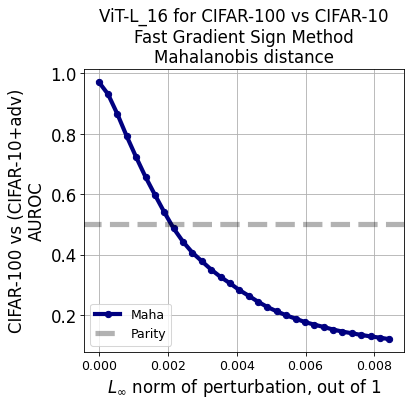

In [137]:
plt.figure(figsize=(5.5,5),dpi=75)
plt.title(model_name+
          " for CIFAR-100 vs CIFAR-10\nFast Gradient Sign Method\nMahalanobis distance",
          fontsize=16)

plt.plot(
    Linfty_values_to_scan,
    np.array(collected_aurocs),
    linewidth=4,
    color="navy",
    marker="o",
    label="Maha",
    )

# to replot later in a combined plot
toreplot_maha_Linfty_xs = Linfty_values_to_scan
toreplot_maha_Linfty_ys = np.array(collected_aurocs)

xlim = plt.gca().get_xlim()

plt.plot([-10,1000],[0.5]*2,linewidth=5,linestyle="--",alpha=0.3,color="black",label="Parity")

plt.xticks(fontsize=12)
plt.yticks(fontsize=16)

plt.grid(True)

plt.xlim(xlim)

plt.legend(fontsize=12,loc=3)

plt.xlabel("$L_\infty$ norm of perturbation, out of 1",fontsize=16)
plt.ylabel("CIFAR-100 vs (CIFAR-10+adv)\nAUROC",fontsize=16)

plt.show()

## Relative Standard Mahalanobis distance adversaries

### An example image finding

In [138]:
batch_now = next(cifar10_ds_test.as_numpy_iterator())
i = 34
image_now = batch_now["image"][i:i+1]
label_now = batch_now["image"][i:i+1]

image_start, scores_list, images_list, L2_perturbation_list, Linfty_perturbation_list = find_adversary(
    image_now,
    label_now,
    steps=30,
    LR=3e-4,
    gradient_signs_only=True,
    first_gradient_only=False,
    top_k_pixels=None,
    target_score=None,
    use_ratio=True,
)

image=34 step=0 OOD score=461.93322954534506
image=34 step=1 OOD score=420.76573188393377
image=34 step=2 OOD score=374.23055965200183
image=34 step=3 OOD score=339.83588182000676
image=34 step=4 OOD score=305.68101377630956
image=34 step=5 OOD score=289.6035872690845
image=34 step=6 OOD score=255.9937023964012
image=34 step=7 OOD score=239.1361304110178
image=34 step=8 OOD score=218.66797212604433
image=34 step=9 OOD score=202.72930285916664
image=34 step=10 OOD score=186.04848925810074
image=34 step=11 OOD score=170.48325721849687
image=34 step=12 OOD score=155.93140009127092
image=34 step=13 OOD score=145.50232200772734
image=34 step=14 OOD score=134.48963359877234
image=34 step=15 OOD score=125.07700583309634
image=34 step=16 OOD score=114.57330732571427
image=34 step=17 OOD score=104.8839698441443
image=34 step=18 OOD score=94.34790033196623
image=34 step=19 OOD score=85.9784415627364
image=34 step=20 OOD score=76.62317652782076
image=34 step=21 OOD score=71.5552340007489
image=34

### A nice plot

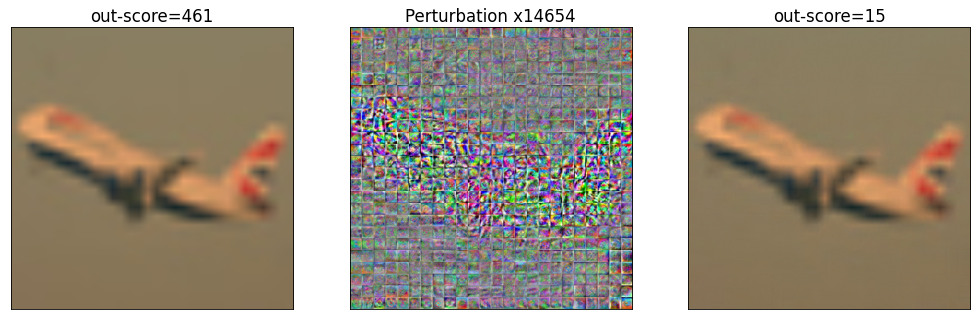

In [139]:
plt.figure(figsize=(3*5.5,5),dpi=75)

plt.subplot(1,3,1)
plt.title("out-score="+str(int(scores_list[0])),fontsize=16)
plt.imshow(np.round((image_start[0])*255).astype(np.uint8))
plt.xticks([],[])
plt.yticks([],[])

plt.subplot(1,3,2)

im_diff = images_list[-1][0]-image_start[0]

diff_range = np.max(im_diff) - np.min(im_diff)

plt.title("Perturbation x"+str(int(255.0/diff_range)),fontsize=16)

im_diff = im_diff -  np.min(im_diff)
im_diff = im_diff/np.max(im_diff)*255

plt.imshow(np.round(im_diff).astype(np.uint8))
plt.xticks([],[])
plt.yticks([],[])

plt.subplot(1,3,3)
plt.title("out-score="+str(int(scores_list[-1])),fontsize=16)
plt.imshow(np.round((images_list[-1][0])*255).astype(np.uint8))
plt.xticks([],[])
plt.yticks([],[])

plt.show()

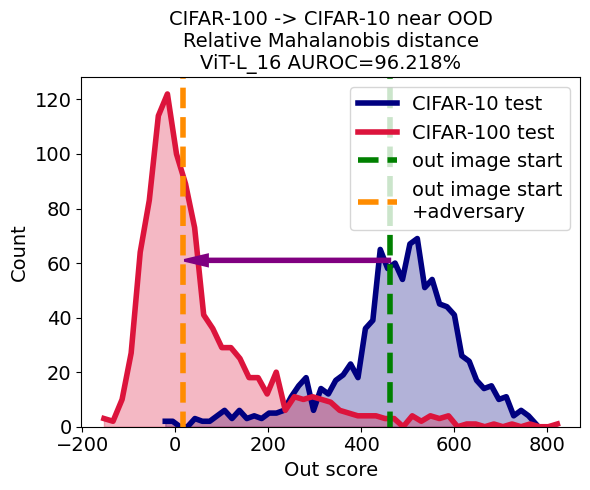

In [140]:
plt.figure(figsize = (6,5),dpi=100)

model_name = "ViT-L_16"

plt.title("CIFAR-100 -> CIFAR-10 near OOD\nRelative Mahalanobis distance\n"+model_name+" AUROC="+str(float(maha_auroc*100))[:6]+"%",fontsize=14)

vals,bins = np.histogram(ratio_outdist_scores,bins = 51)
bin_centers = (bins[1:]+bins[:-1])/2.0

plt.plot(bin_centers,vals,linewidth=4,color="navy",marker="",label="CIFAR-10 test")
plt.fill_between(bin_centers,vals,[0]*len(vals),color="navy",alpha=0.3)

vals,bins = np.histogram(ratio_indist_scores,bins = 51)
bin_centers = (bins[1:]+bins[:-1])/2.0

plt.plot(bin_centers,vals,linewidth=4,color="crimson",marker="",label="CIFAR-100 test")
plt.fill_between(bin_centers,vals,[0]*len(vals),color="crimson",alpha=0.3)

plt.xlabel("Out score",fontsize=14)
plt.ylabel("Count",fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ylim = plt.gca().get_ylim()

plt.plot([scores_list[0]]*2,[-100,10000],color="green",linewidth=4,
         label="out image start",linestyle="--")

plt.plot([scores_list[-1]]*2,[-100,10000],color="darkorange",linewidth=4,
         label="out image start\n+adversary",linestyle="--")

plt.arrow(scores_list[0],np.mean(ylim),(scores_list[-1]-scores_list[0])*0.88,0,
          linewidth=2,color="purple",width=1,head_width=4,head_length=50,zorder=9)

plt.ylim([0,ylim[-1]])

plt.legend(fontsize = 14)

plt.tight_layout()
plt.show()

### Many images at once

In [141]:
images_count = 64 #for a faster run you can generate a small amount

steps = 30
LR = 3e-4

batch_now = next(cifar10_ds_test.as_numpy_iterator())

scores_grid = np.zeros((images_count,steps))*float("NaN")
L2_perturbation_sizes = np.zeros((images_count,steps))*float("NaN")
Linfty_perturbation_sizes = np.zeros((images_count,steps))*float("NaN")

times = []

for i in range(images_count):

  t1_now = time.time()

  image_now = batch_now["image"][i:i+1]
  label_now = batch_now["image"][i:i+1]

  image_start, scores_list, images_list, L2_perturbation_list, Linfty_perturbation_list = find_adversary(
      image_now,
      label_now,
      steps=steps,
      LR=LR,
      gradient_signs_only=True,
      first_gradient_only=False,
      top_k_pixels=None,
      target_score=None,
      use_ratio=True,
      verbose=steps-1,
  )

  scores_grid[i] = np.array(scores_list)
  L2_perturbation_sizes[i] = np.array(L2_perturbation_list)
  Linfty_perturbation_sizes[i] = np.array(Linfty_perturbation_list)

  t2_now = time.time()
  
  times.append(t2_now-t1_now)
  t_rem = np.mean(times)*images_count - np.sum(times)
  print("t_remaining = "+str(int(t_rem))+" seconds")


image=0 step=0 OOD score=583.11966867093
image=0 step=29 OOD score=-20.934496434172615
t_remaining = 1027 seconds
image=1 step=0 OOD score=733.8488702010363
image=1 step=29 OOD score=-124.32190744008403
t_remaining = 1010 seconds
image=2 step=0 OOD score=415.9691285431618
image=2 step=29 OOD score=22.686836878885515
t_remaining = 993 seconds
image=3 step=0 OOD score=516.6292171734385
image=3 step=29 OOD score=-121.20582190307323
t_remaining = 976 seconds
image=4 step=0 OOD score=579.9538573198952
image=4 step=29 OOD score=-149.7913320955704
t_remaining = 960 seconds
image=5 step=0 OOD score=672.8512481325306
image=5 step=29 OOD score=121.33471874758834
t_remaining = 943 seconds
image=6 step=0 OOD score=506.1166950003244
image=6 step=29 OOD score=18.897369412588887
t_remaining = 928 seconds
image=7 step=0 OOD score=480.0932630961761
image=7 step=29 OOD score=-34.42000746051781
t_remaining = 911 seconds
image=8 step=0 OOD score=315.53887424524873
image=8 step=29 OOD score=-93.94852041779

### Score vs perturbation norm

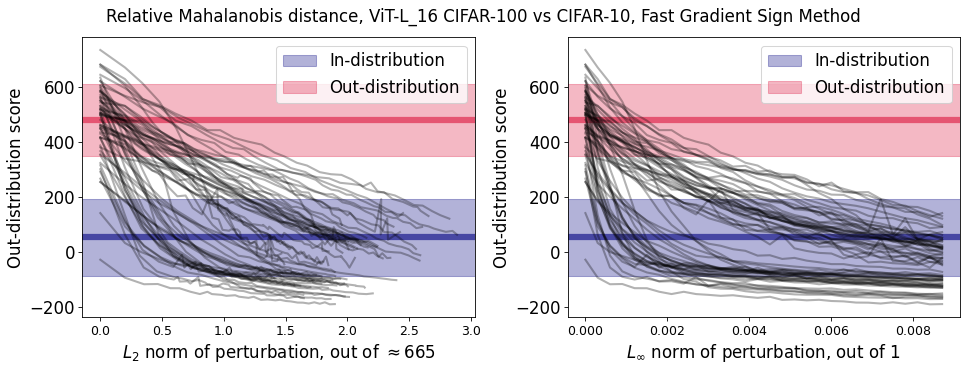

In [142]:
plt.figure(figsize=(2*6.5,5),dpi=75)
plt.suptitle("Relative Mahalanobis distance, "+model_name+" CIFAR-100 vs CIFAR-10, Fast Gradient Sign Method",fontsize=16)

plt.subplot(1,2,1)

for i in range(images_count):
  if True:
    plt.plot(L2_perturbation_sizes[i],scores_grid[i],linewidth=2,color="black",
           marker="",alpha=0.3,zorder=100)

plt.xticks(fontsize=12)
plt.yticks(fontsize=16)

indist_mean = np.mean(ratio_indist_scores)
indist_std = np.std(ratio_indist_scores)

xlim = plt.gca().get_xlim()

x_range = [
           np.min(L2_perturbation_sizes[~np.isnan(L2_perturbation_sizes)])-100,
           np.max(L2_perturbation_sizes[~np.isnan(L2_perturbation_sizes)])+100
]

plt.plot(x_range,[indist_mean]*2,linewidth=6,alpha=0.6,color="navy")
plt.fill_between(x_range,
                 [indist_mean-indist_std]*2,
                 [indist_mean+indist_std]*2,
                 alpha=0.3,color="navy",label="In-distribution")


outdist_mean = np.mean(ratio_outdist_scores)
outdist_std = np.std(ratio_outdist_scores)

plt.plot(x_range,[outdist_mean]*2,linewidth=6,alpha=0.6,color="crimson")
plt.fill_between(x_range,
                 [outdist_mean-outdist_std]*2,
                 [outdist_mean+outdist_std]*2,
                 alpha=0.3,color="crimson",label="Out-distribution")

plt.xlim(xlim)

plt.legend(fontsize=16)

plt.xlabel("$L_2$ norm of perturbation, out of $\\approx$665",fontsize=16)
plt.ylabel("Out-distribution score",fontsize=16)


plt.subplot(1,2,2)

for i in range(images_count):
  if True:
    plt.plot(Linfty_perturbation_sizes[i],scores_grid[i],linewidth=2,color="black",
           marker="",alpha=0.3,zorder=100)

plt.xticks(fontsize=12)
plt.yticks(fontsize=16)

indist_mean = np.mean(ratio_indist_scores)
indist_std = np.std(ratio_indist_scores)

xlim = plt.gca().get_xlim()

x_range = [
           np.min(Linfty_perturbation_sizes[~np.isnan(Linfty_perturbation_sizes)])-100,
           np.max(Linfty_perturbation_sizes[~np.isnan(Linfty_perturbation_sizes)])+100
]

plt.plot(x_range,[indist_mean]*2,linewidth=6,alpha=0.6,color="navy")
plt.fill_between(x_range,
                 [indist_mean-indist_std]*2,
                 [indist_mean+indist_std]*2,
                 alpha=0.3,color="navy",label="In-distribution")


outdist_mean = np.mean(ratio_outdist_scores)
outdist_std = np.std(ratio_outdist_scores)

plt.plot(x_range,[outdist_mean]*2,linewidth=6,alpha=0.6,color="crimson")
plt.fill_between(x_range,
                 [outdist_mean-outdist_std]*2,
                 [outdist_mean+outdist_std]*2,
                 alpha=0.3,color="crimson",label="Out-distribution")

plt.xlim(xlim)

plt.legend(fontsize=16)

plt.xlabel("$L_\infty$ norm of perturbation, out of 1",fontsize=16)
plt.ylabel("Out-distribution score",fontsize=16)

plt.tight_layout()
plt.subplots_adjust(top=0.9)

plt.show()

### Getting AUROCs

In [143]:
auroc_list = []
for j in range(steps):

  bools = ~np.isnan(scores_grid[:,j])
  # print(np.sum(bools),len(bools))

  onehots = np.array([1]*len(scores_grid[:,j][bools]) + [0]*len(ratio_indist_scores[:]))
  scores = np.concatenate([scores_grid[:,j][bools],ratio_indist_scores[:]],axis=0)

  auroc, _ = get_auroc(onehots, scores, make_plot=False)

  auroc_list.append(auroc)

### Interpolating $L_2$ perturbations

In [144]:
import matplotlib.pyplot as plt
from scipy import interpolate

L2_to_score_interpolated_fns = []

for i in range(len(scores_grid)):
  x_now = L2_perturbation_sizes[i]
  y_now = scores_grid[i]

  f_now = interpolate.interp1d(x_now, y_now)
  L2_to_score_interpolated_fns.append(f_now)

In [145]:
L2_values_to_scan = np.linspace(
    np.min(L2_perturbation_sizes),
    np.max(L2_perturbation_sizes),
    33
)

collected_aurocs = []

indist_scores = ratio_indist_scores

for i,L2_now in enumerate(L2_values_to_scan):

  bools_morethanmin = L2_now >= np.min(L2_perturbation_sizes,axis=1) 
  bools_lessthanmax = L2_now <= np.max(L2_perturbation_sizes,axis=1) 
  bools = np.logical_and(bools_morethanmin,bools_lessthanmax)

  if np.sum(~bools) == 0: # not missing any images

    scores_selected = [f_now(L2_now) for (i,f_now) in enumerate(L2_to_score_interpolated_fns) if bools[i]]

    onehots = np.array([1]*len(scores_selected) + [0]*len(indist_scores[:]))
    scores = np.concatenate([scores_selected,indist_scores[:]],axis=0)

    auroc,_ = get_auroc(onehots, scores, make_plot=False)

  else:
    auroc = float("NaN")

  collected_aurocs.append(auroc)

### Plotting AUROC vs $L_2$ norm

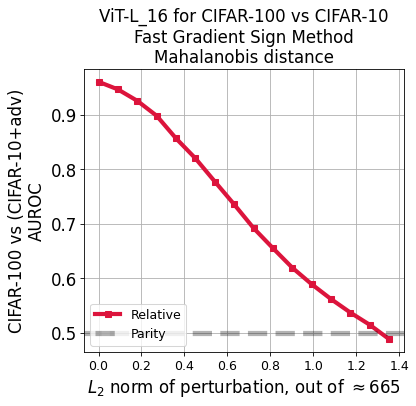

In [146]:
plt.figure(figsize=(5.5,5),dpi=75)
plt.title(model_name+
          " for CIFAR-100 vs CIFAR-10\nFast Gradient Sign Method\nMahalanobis distance",
          fontsize=16)

plt.plot(
    L2_values_to_scan,
    np.array(collected_aurocs),
    linewidth=4,
    color="crimson",
    marker="s",
    label="Relative",
    )

# to replot later in a combined plot
toreplot_ratio_L2_xs = L2_values_to_scan
toreplot_ratio_L2_ys = np.array(collected_aurocs)

xlim = plt.gca().get_xlim()

plt.plot([-10,1000],[0.5]*2,linewidth=5,linestyle="--",alpha=0.3,color="black",label="Parity")

plt.xticks(fontsize=12)
plt.yticks(fontsize=16)

plt.grid(True)

plt.xlim(xlim)

plt.legend(fontsize=12,loc=3)

plt.xlabel("$L_2$ norm of perturbation, out of $\\approx$665",fontsize=16)
plt.ylabel("CIFAR-100 vs (CIFAR-10+adv)\nAUROC",fontsize=16)

plt.show()

### Interpolating $L_\infty$ perturbations

In [147]:
import matplotlib.pyplot as plt
from scipy import interpolate

Linfty_to_score_interpolated_fns = []

for i in range(len(scores_grid)):
  x_now = Linfty_perturbation_sizes[i]
  y_now = scores_grid[i]

  f_now = interpolate.interp1d(x_now, y_now)
  Linfty_to_score_interpolated_fns.append(f_now)

In [148]:
Linfty_values_to_scan = np.linspace(
    np.min(Linfty_perturbation_sizes),
    np.max(Linfty_perturbation_sizes),
    33
)

collected_aurocs = []

indist_scores = ratio_indist_scores

for i,Linfty_now in enumerate(Linfty_values_to_scan):

  bools_morethanmin = Linfty_now >= np.min(Linfty_perturbation_sizes,axis=1) 
  bools_lessthanmax = Linfty_now <= np.max(Linfty_perturbation_sizes,axis=1) 
  bools = np.logical_and(bools_morethanmin,bools_lessthanmax)

  if np.sum(~bools) == 0: # not missing any images

    scores_selected = [f_now(Linfty_now) for (i,f_now) in enumerate(Linfty_to_score_interpolated_fns) if bools[i]]

    onehots = np.array([1]*len(scores_selected) + [0]*len(indist_scores[:]))
    scores = np.concatenate([scores_selected,indist_scores[:]],axis=0)

    auroc,_ = get_auroc(onehots, scores, make_plot=False)

  else:
    auroc = float("NaN")

  collected_aurocs.append(auroc)

### Plotting AUROC vs $L_\infty$ norm

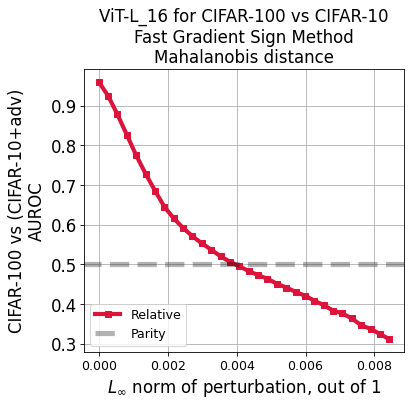

In [149]:
plt.figure(figsize=(5.5,5),dpi=75)
plt.title(model_name+
          " for CIFAR-100 vs CIFAR-10\nFast Gradient Sign Method\nMahalanobis distance",
          fontsize=16)

plt.plot(
    Linfty_values_to_scan,
    np.array(collected_aurocs),
    linewidth=4,
    color="crimson",
    marker="s",
    label="Relative",
    )

# to replot later in a combined plot
toreplot_ratio_Linfty_xs = Linfty_values_to_scan
toreplot_ratio_Linfty_ys = np.array(collected_aurocs)

xlim = plt.gca().get_xlim()

plt.plot([-10,1000],[0.5]*2,linewidth=5,linestyle="--",alpha=0.3,color="black",label="Parity")

plt.xticks(fontsize=12)
plt.yticks(fontsize=16)

plt.grid(True)

plt.xlim(xlim)

plt.legend(fontsize=12,loc=3)

plt.xlabel("$L_\infty$ norm of perturbation, out of 1",fontsize=16)
plt.ylabel("CIFAR-100 vs (CIFAR-10+adv)\nAUROC",fontsize=16)

plt.show()

## Maximum of Softmax Probabilities

### Score and gradient tools

In [150]:
def get_score_with_MSP(
    image, 
    params
    ):

  assert image.shape[0] == 1

  logits = model.apply({'params': params}, image, train=False)
  probs = jax.nn.softmax(logits,axis=-1)

  score = jnp.max(probs,axis=-1)[0]
  return score

In [151]:
def get_input_grad_with_MSP(image,params):
  return jax.grad(
      lambda image_in: get_score_with_MSP(image_in,params)
  )(image)

In [152]:
get_score_with_MSP_jit = jax.jit(get_score_with_MSP)
get_input_grad_with_MSP_jit = jax.jit(get_input_grad_with_MSP)

In [153]:
def find_adversary_against_MSP(
    start_image,
    label_now,
    steps=30,
    LR=3e-4,
    gradient_signs_only=True,
    first_gradient_only=False,
    top_k_pixels=None,
    target_score=None,
    verbose=1,
):


  image_now = start_image
  image_start = image_now

  scores_list = []
  images_list = []
  L2_perturbation_list = []
  Linfty_perturbation_list = []

  for it in range(steps):

    score_now = get_score_with_MSP_jit(
        image_now,
        params,
        )
    
    #early stopping
    if (target_score is not None) and (score_now < target_score):
      break
    
    images_list.append(image_now)

    scores_list.append(score_now)
    L2_perturbation_list.append(np.linalg.norm(image_now - image_start))
    Linfty_perturbation_list.append(np.max(np.abs(image_now - image_start)))
    
    if it == 0:
      score_start = score_now
    
    if it % verbose == 0:
      print("image="+str(i)+" step="+str(it)+" OOD score="+str(score_now))
    
    if ((first_gradient_only == False) or (it==0)): 
      image_grad_now = get_input_grad_with_MSP_jit(
          image_now,
          params,
          )
    
    if gradient_signs_only:
      image_grad_now = ((image_grad_now>0.0)*2.0-1.0)


    image_now = image_now - LR*image_grad_now



  return image_start, scores_list, images_list, L2_perturbation_list, Linfty_perturbation_list


### An example image finding

In [154]:
batch_now = next(cifar10_ds_test.as_numpy_iterator())
i = 34
image_now = batch_now["image"][i:i+1]
label_now = batch_now["image"][i:i+1]

image_start, scores_list, images_list, L2_perturbation_list, Linfty_perturbation_list = find_adversary_against_MSP(
    image_now,
    label_now,
    steps=30,
    LR=-3e-4, #the score here is reversed
    gradient_signs_only=True,
    first_gradient_only=False,
    top_k_pixels=None,
    target_score=None,
)

image=34 step=0 OOD score=0.3001277
image=34 step=1 OOD score=0.72100335
image=34 step=2 OOD score=0.95026577
image=34 step=3 OOD score=0.98849547
image=34 step=4 OOD score=0.99659747
image=34 step=5 OOD score=0.99856395
image=34 step=6 OOD score=0.9992017
image=34 step=7 OOD score=0.9995428
image=34 step=8 OOD score=0.99968296
image=34 step=9 OOD score=0.9997658
image=34 step=10 OOD score=0.9998027
image=34 step=11 OOD score=0.9998051
image=34 step=12 OOD score=0.999825
image=34 step=13 OOD score=0.99985516
image=34 step=14 OOD score=0.9998547
image=34 step=15 OOD score=0.9998754
image=34 step=16 OOD score=0.99987817
image=34 step=17 OOD score=0.99988806
image=34 step=18 OOD score=0.99989855
image=34 step=19 OOD score=0.9999049
image=34 step=20 OOD score=0.9999132
image=34 step=21 OOD score=0.9999188
image=34 step=22 OOD score=0.9999263
image=34 step=23 OOD score=0.99992764
image=34 step=24 OOD score=0.9999342
image=34 step=25 OOD score=0.99993503
image=34 step=26 OOD score=0.9999399


### A nice plot

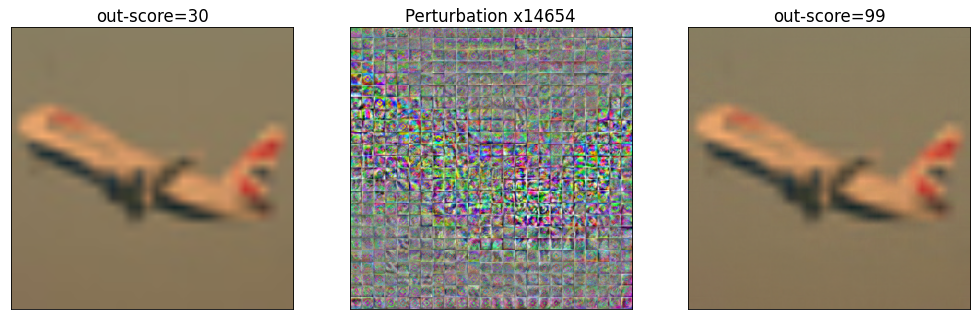

In [155]:
plt.figure(figsize=(3*5.5,5),dpi=75)

plt.subplot(1,3,1)
plt.title("out-score="+str(int(100*scores_list[0])),fontsize=16)
plt.imshow(np.round((image_start[0])*255).astype(np.uint8))
plt.xticks([],[])
plt.yticks([],[])

plt.subplot(1,3,2)

im_diff = images_list[-1][0]-image_start[0]

diff_range = np.max(im_diff) - np.min(im_diff)

plt.title("Perturbation x"+str(int(255.0/diff_range)),fontsize=16)

im_diff = im_diff -  np.min(im_diff)
im_diff = im_diff/np.max(im_diff)*255

plt.imshow(np.round(im_diff).astype(np.uint8))
plt.xticks([],[])
plt.yticks([],[])

plt.subplot(1,3,3)
plt.title("out-score="+str(int(100*scores_list[-1])),fontsize=16)
plt.imshow(np.round((images_list[-1][0])*255).astype(np.uint8))
plt.xticks([],[])
plt.yticks([],[])

plt.show()

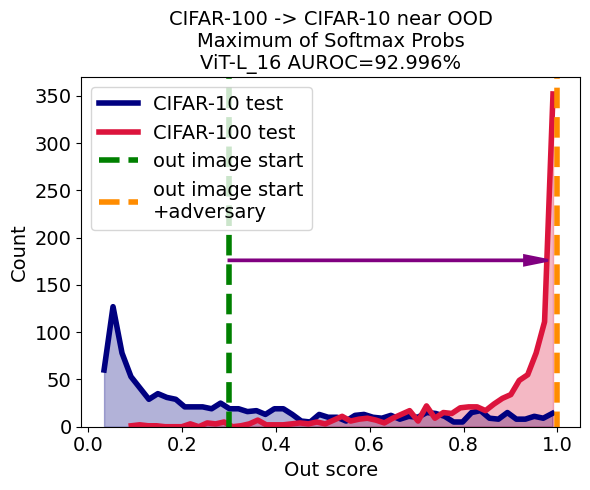

In [156]:
plt.figure(figsize = (6,5),dpi=100)

model_name = "ViT-L_16"

plt.title("CIFAR-100 -> CIFAR-10 near OOD\nMaximum of Softmax Probs\n"+model_name+" AUROC="+str(float(MSP_auroc*100))[:6]+"%",fontsize=14)

vals,bins = np.histogram(MSP_outdist_scores,bins = 51)
bin_centers = (bins[1:]+bins[:-1])/2.0

plt.plot(bin_centers,vals,linewidth=4,color="navy",marker="",label="CIFAR-10 test")
plt.fill_between(bin_centers,vals,[0]*len(vals),color="navy",alpha=0.3)

vals,bins = np.histogram(MSP_indist_scores,bins = 51)
bin_centers = (bins[1:]+bins[:-1])/2.0

plt.plot(bin_centers,vals,linewidth=4,color="crimson",marker="",label="CIFAR-100 test")
plt.fill_between(bin_centers,vals,[0]*len(vals),color="crimson",alpha=0.3)

plt.xlabel("Out score",fontsize=14)
plt.ylabel("Count",fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ylim = plt.gca().get_ylim()

plt.plot([scores_list[0]]*2,[-100,10000],color="green",linewidth=4,
         label="out image start",linestyle="--")

plt.plot([scores_list[-1]]*2,[-100,10000],color="darkorange",linewidth=4,
         label="out image start\n+adversary",linestyle="--")

plt.arrow(scores_list[0],np.mean(ylim),(scores_list[-1]-scores_list[0])*0.90,0,
          linewidth=2,color="purple",width=1,head_width=10,head_length=0.05,zorder=9)

plt.ylim([0,ylim[-1]])

plt.legend(fontsize = 14)

plt.tight_layout()
plt.show()

### Many images at once

In [157]:
images_count = 64 #64 #for a faster run you can generate a small amount

steps = 30
LR = -3e-4 #need to reverse the sign here

batch_now = next(cifar10_ds_test.as_numpy_iterator())

scores_grid = np.zeros((images_count,steps))*float("NaN")
L2_perturbation_sizes = np.zeros((images_count,steps))*float("NaN")
Linfty_perturbation_sizes = np.zeros((images_count,steps))*float("NaN")

times = []

for i in range(images_count):

  t1_now = time.time()

  image_now = batch_now["image"][i:i+1]
  label_now = batch_now["image"][i:i+1]

  image_start, scores_list, images_list, L2_perturbation_list, Linfty_perturbation_list = find_adversary_against_MSP(
      image_now,
      label_now,
      steps=steps,
      LR=LR,
      gradient_signs_only=True,
      first_gradient_only=False,
      top_k_pixels=None,
      target_score=None,
      verbose=steps-1,
  )

  scores_grid[i] = np.array(scores_list)
  L2_perturbation_sizes[i] = np.array(L2_perturbation_list)
  Linfty_perturbation_sizes[i] = np.array(Linfty_perturbation_list)

  t2_now = time.time()
  
  times.append(t2_now-t1_now)
  t_rem = np.mean(times)*images_count - np.sum(times)
  print("t_remaining = "+str(int(t_rem))+" seconds")


image=0 step=0 OOD score=0.26397312
image=0 step=29 OOD score=0.9999833
t_remaining = 1007 seconds
image=1 step=0 OOD score=0.33570388
image=1 step=29 OOD score=0.99994934
t_remaining = 990 seconds
image=2 step=0 OOD score=0.049807623
image=2 step=29 OOD score=0.9999701
t_remaining = 974 seconds
image=3 step=0 OOD score=0.53242767
image=3 step=29 OOD score=0.99979997
t_remaining = 959 seconds
image=4 step=0 OOD score=0.044136487
image=4 step=29 OOD score=0.99988365
t_remaining = 943 seconds
image=5 step=0 OOD score=0.40914634
image=5 step=29 OOD score=0.99992776
t_remaining = 927 seconds
image=6 step=0 OOD score=0.05150877
image=6 step=29 OOD score=0.94968486
t_remaining = 911 seconds
image=7 step=0 OOD score=0.25989103
image=7 step=29 OOD score=0.9999521
t_remaining = 895 seconds
image=8 step=0 OOD score=0.73154366
image=8 step=29 OOD score=0.9999521
t_remaining = 879 seconds
image=9 step=0 OOD score=0.6815104
image=9 step=29 OOD score=0.9998716
t_remaining = 863 seconds
image=10 step

### Score vs perturbation norm

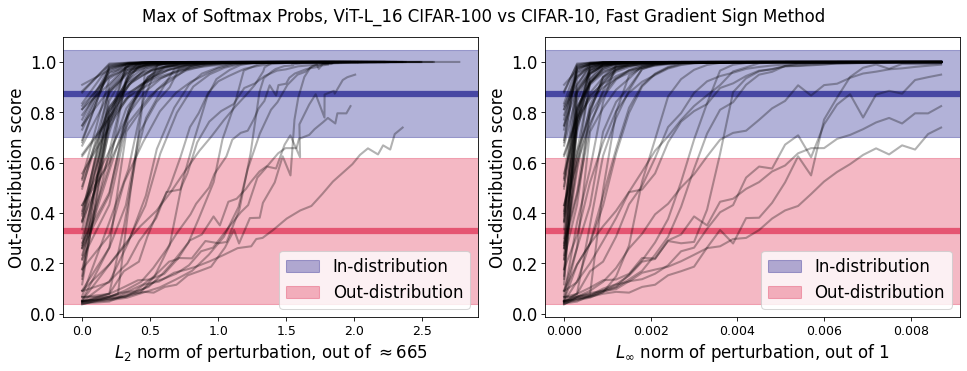

In [158]:
plt.figure(figsize=(2*6.5,5),dpi=75)
plt.suptitle("Max of Softmax Probs, "+model_name+" CIFAR-100 vs CIFAR-10, Fast Gradient Sign Method",fontsize=16)

plt.subplot(1,2,1)

for i in range(images_count):
  if True:
    plt.plot(L2_perturbation_sizes[i],scores_grid[i],linewidth=2,color="black",
           marker="",alpha=0.3,zorder=100)

plt.xticks(fontsize=12)
plt.yticks(fontsize=16)

indist_mean = np.mean(MSP_indist_scores)
indist_std = np.std(MSP_indist_scores)

xlim = plt.gca().get_xlim()

x_range = [
           np.min(L2_perturbation_sizes[~np.isnan(L2_perturbation_sizes)])-100,
           np.max(L2_perturbation_sizes[~np.isnan(L2_perturbation_sizes)])+100
]

plt.plot(x_range,[indist_mean]*2,linewidth=6,alpha=0.6,color="navy")
plt.fill_between(x_range,
                 [indist_mean-indist_std]*2,
                 [indist_mean+indist_std]*2,
                 alpha=0.3,color="navy",label="In-distribution")


outdist_mean = np.mean(MSP_outdist_scores)
outdist_std = np.std(MSP_outdist_scores)

plt.plot(x_range,[outdist_mean]*2,linewidth=6,alpha=0.6,color="crimson")
plt.fill_between(x_range,
                 [outdist_mean-outdist_std]*2,
                 [outdist_mean+outdist_std]*2,
                 alpha=0.3,color="crimson",label="Out-distribution")

plt.xlim(xlim)

plt.legend(fontsize=16)

plt.xlabel("$L_2$ norm of perturbation, out of $\\approx$665",fontsize=16)
plt.ylabel("Out-distribution score",fontsize=16)


plt.subplot(1,2,2)

for i in range(images_count):
  if True:
    plt.plot(Linfty_perturbation_sizes[i],scores_grid[i],linewidth=2,color="black",
           marker="",alpha=0.3,zorder=100)

plt.xticks(fontsize=12)
plt.yticks(fontsize=16)

indist_mean = np.mean(MSP_indist_scores)
indist_std = np.std(MSP_indist_scores)

xlim = plt.gca().get_xlim()

x_range = [
           np.min(Linfty_perturbation_sizes[~np.isnan(Linfty_perturbation_sizes)])-100,
           np.max(Linfty_perturbation_sizes[~np.isnan(Linfty_perturbation_sizes)])+100
]

plt.plot(x_range,[indist_mean]*2,linewidth=6,alpha=0.6,color="navy")
plt.fill_between(x_range,
                 [indist_mean-indist_std]*2,
                 [indist_mean+indist_std]*2,
                 alpha=0.3,color="navy",label="In-distribution")


outdist_mean = np.mean(MSP_outdist_scores)
outdist_std = np.std(MSP_outdist_scores)

plt.plot(x_range,[outdist_mean]*2,linewidth=6,alpha=0.6,color="crimson")
plt.fill_between(x_range,
                 [outdist_mean-outdist_std]*2,
                 [outdist_mean+outdist_std]*2,
                 alpha=0.3,color="crimson",label="Out-distribution")

plt.xlim(xlim)

plt.legend(fontsize=16)

plt.xlabel("$L_\infty$ norm of perturbation, out of 1",fontsize=16)
plt.ylabel("Out-distribution score",fontsize=16)

plt.tight_layout()
plt.subplots_adjust(top=0.9)

plt.show()

### Getting AUROCs

In [159]:
auroc_list = []
for j in range(steps):

  bools = ~np.isnan(scores_grid[:,j])
  # print(np.sum(bools),len(bools))

  onehots = np.array([1]*len(scores_grid[:,j][bools]) + [0]*len(maha_indist_scores[:]))
  scores = np.concatenate([scores_grid[:,j][bools],maha_indist_scores[:]],axis=0)

  auroc, _ = get_auroc(onehots, scores, make_plot=False)

  auroc_list.append(auroc)

### Interpolating $L_2$ perturbations

In [160]:
import matplotlib.pyplot as plt
from scipy import interpolate

L2_to_score_interpolated_fns = []

for i in range(len(scores_grid)):
  x_now = L2_perturbation_sizes[i]
  y_now = scores_grid[i]

  f_now = interpolate.interp1d(x_now, y_now)
  L2_to_score_interpolated_fns.append(f_now)

In [161]:
L2_values_to_scan = np.linspace(
    np.min(L2_perturbation_sizes),
    np.max(L2_perturbation_sizes),
    33
)

collected_aurocs = []

indist_scores = MSP_indist_scores

for i,L2_now in enumerate(L2_values_to_scan):

  bools_morethanmin = L2_now >= np.min(L2_perturbation_sizes,axis=1) 
  bools_lessthanmax = L2_now <= np.max(L2_perturbation_sizes,axis=1) 
  bools = np.logical_and(bools_morethanmin,bools_lessthanmax)

  if np.sum(~bools) == 0: # not missing any images

    scores_selected = [f_now(L2_now) for (i,f_now) in enumerate(L2_to_score_interpolated_fns) if bools[i]]

    onehots = np.array([0]*len(scores_selected) + [1]*len(indist_scores[:]))
    scores = np.concatenate([scores_selected,indist_scores[:]],axis=0)

    auroc,_ = get_auroc(onehots, scores, make_plot=False)

  else:
    auroc = float("NaN")

  collected_aurocs.append(auroc)

### Plotting AUROC vs $L_2$ norm

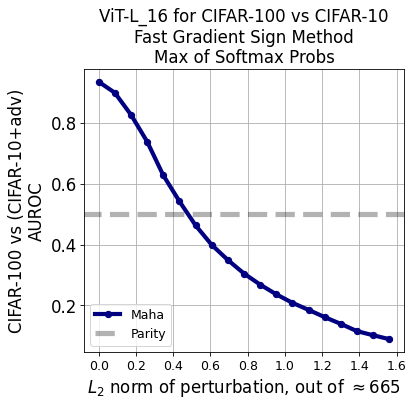

In [162]:
plt.figure(figsize=(5.5,5),dpi=75)
plt.title(model_name+
          " for CIFAR-100 vs CIFAR-10\nFast Gradient Sign Method\nMax of Softmax Probs",
          fontsize=16)

plt.plot(
    L2_values_to_scan,
    np.array(collected_aurocs),
    linewidth=4,
    color="navy",
    marker="o",
    label="Maha",
    )

# to replot later in a combined plot
toreplot_MSP_L2_xs = L2_values_to_scan
toreplot_MSP_L2_ys = np.array(collected_aurocs)

xlim = plt.gca().get_xlim()

plt.plot([-10,1000],[0.5]*2,linewidth=5,linestyle="--",alpha=0.3,color="black",label="Parity")

plt.xticks(fontsize=12)
plt.yticks(fontsize=16)

plt.grid(True)

plt.xlim(xlim)

plt.legend(fontsize=12,loc=3)

plt.xlabel("$L_2$ norm of perturbation, out of $\\approx$665",fontsize=16)
plt.ylabel("CIFAR-100 vs (CIFAR-10+adv)\nAUROC",fontsize=16)

plt.show()

### Interpolating $L_\infty$ perturbations

In [163]:
import matplotlib.pyplot as plt
from scipy import interpolate

Linfty_to_score_interpolated_fns = []

for i in range(len(scores_grid)):
  x_now = Linfty_perturbation_sizes[i]
  y_now = scores_grid[i]

  f_now = interpolate.interp1d(x_now, y_now)
  Linfty_to_score_interpolated_fns.append(f_now)

In [164]:
Linfty_values_to_scan = np.linspace(
    np.min(Linfty_perturbation_sizes),
    np.max(Linfty_perturbation_sizes),
    33
)

collected_aurocs = []

indist_scores = MSP_indist_scores

for i,Linfty_now in enumerate(Linfty_values_to_scan):

  bools_morethanmin = Linfty_now >= np.min(Linfty_perturbation_sizes,axis=1) 
  bools_lessthanmax = Linfty_now <= np.max(Linfty_perturbation_sizes,axis=1) 
  bools = np.logical_and(bools_morethanmin,bools_lessthanmax)

  if np.sum(~bools) == 0: # not missing any images

    scores_selected = [f_now(Linfty_now) for (i,f_now) in enumerate(Linfty_to_score_interpolated_fns) if bools[i]]

    onehots = np.array([0]*len(scores_selected) + [1]*len(indist_scores[:]))
    scores = np.concatenate([scores_selected,indist_scores[:]],axis=0)

    auroc,_ = get_auroc(onehots, scores, make_plot=False)

  else:
    auroc = float("NaN")

  collected_aurocs.append(auroc)

### Plotting AUROC vs $L_\infty$ norm

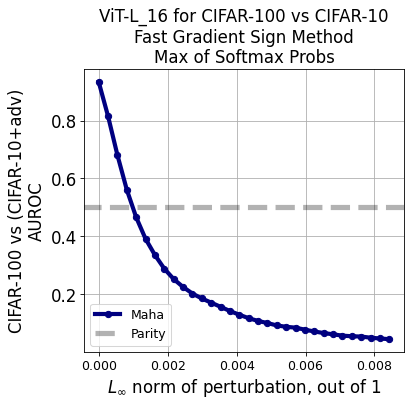

In [165]:
plt.figure(figsize=(5.5,5),dpi=75)
plt.title(model_name+
          " for CIFAR-100 vs CIFAR-10\nFast Gradient Sign Method\nMax of Softmax Probs",
          fontsize=16)

plt.plot(
    Linfty_values_to_scan,
    np.array(collected_aurocs),
    linewidth=4,
    color="navy",
    marker="o",
    label="Maha",
    )

# to replot later in a combined plot
toreplot_MSP_Linfty_xs = Linfty_values_to_scan
toreplot_MSP_Linfty_ys = np.array(collected_aurocs)

xlim = plt.gca().get_xlim()

plt.plot([-10,1000],[0.5]*2,linewidth=5,linestyle="--",alpha=0.3,color="black",label="Parity")

plt.grid(True)

plt.xlim(xlim)

plt.legend(fontsize=12,loc=3)

plt.xlabel("$L_\infty$ norm of perturbation, out of 1",fontsize=16)
plt.ylabel("CIFAR-100 vs (CIFAR-10+adv)\nAUROC",fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=16)

plt.show()

## Combining the Standard and Relative Mahalanobis distance, and Max of Softmax Probs plots

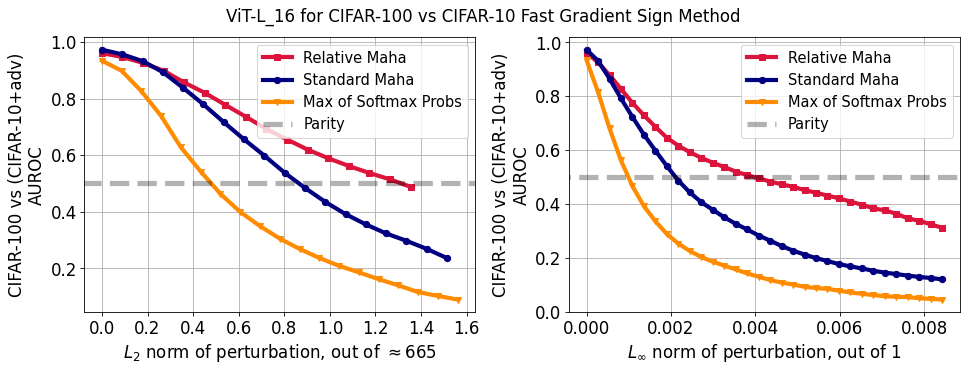

In [167]:
plt.figure(figsize=(2*6.5,5),dpi=75)
plt.suptitle(model_name+
          " for CIFAR-100 vs CIFAR-10 Fast Gradient Sign Method",
          fontsize=16)

plt.subplot(1,2,1)

plt.plot(
    toreplot_ratio_L2_xs,
    toreplot_ratio_L2_ys,
    linewidth=4,
    color="crimson",
    marker="s",
    label="Relative Maha",
    )

plt.plot(
    toreplot_maha_L2_xs,
    toreplot_maha_L2_ys,
    linewidth=4,
    color="navy",
    marker="o",
    label="Standard Maha",
    )

plt.plot(
    toreplot_MSP_L2_xs,
    toreplot_MSP_L2_ys,
    linewidth=4,
    color="darkorange",
    marker="v",
    label="Max of Softmax Probs",
    )

xlim = plt.gca().get_xlim()

plt.plot([-10,1000],[0.5]*2,linewidth=5,linestyle="--",alpha=0.3,color="black",label="Parity")

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.grid(True)

plt.xlim(xlim)

plt.legend(fontsize=14,loc=1)

plt.xlabel("$L_2$ norm of perturbation, out of $\\approx$665",fontsize=16)
plt.ylabel("CIFAR-100 vs (CIFAR-10+adv)\nAUROC",fontsize=16)


plt.subplot(1,2,2)

plt.plot(
    toreplot_ratio_Linfty_xs,
    toreplot_ratio_Linfty_ys,
    linewidth=4,
    color="crimson",
    marker="s",
    label="Relative Maha",
    )

plt.plot(
    toreplot_maha_Linfty_xs,
    toreplot_maha_Linfty_ys,
    linewidth=4,
    color="navy",
    marker="o",
    label="Standard Maha",
    )

plt.plot(
    toreplot_MSP_Linfty_xs,
    toreplot_MSP_Linfty_ys,
    linewidth=4,
    color="darkorange",
    marker="v",
    label="Max of Softmax Probs",
    )

xlim = plt.gca().get_xlim()

plt.plot([-10,1000],[0.5]*2,linewidth=5,linestyle="--",alpha=0.3,color="black",label="Parity")

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.grid(True)

plt.xlim(xlim)

plt.legend(fontsize=14,loc=1)

plt.xlabel("$L_\infty$ norm of perturbation, out of 1",fontsize=16)
plt.ylabel("CIFAR-100 vs (CIFAR-10+adv)\nAUROC",fontsize=16)

plt.tight_layout()
plt.subplots_adjust(top=0.9)

plt.show()